# check sessions based on previously calculated participation.

needed to check ripple participation calculated in *matlab* (CellExplorer/+customCalculations/swr_unit_metrics.m) to the one calculated in *python* (ripple_heterogeneity/ripple_heterogeneity/utils/functions.py get_participation)

Conclusion:
    They are the same... see plots below

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.replay import replay_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [4]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\replay"

df = replay_run.load_results(save_path)


In [5]:
df = df[(df.decoding_r2_pval < 0.05) & (df.decoding_median_error < 30)]


In [6]:
cell_metrics = loading.load_all_cell_metrics(df.basepath.unique())


In [ ]:
layer_dist = 30
deep = -layer_dist
middle = [-layer_dist, layer_dist]
sup = layer_dist
cell_metrics.loc[
    cell_metrics.deepSuperficialDistance <= deep, "deepSuperficial"
] = "Deep"
cell_metrics.loc[
    (cell_metrics.deepSuperficialDistance > middle[0])
    & (cell_metrics.deepSuperficialDistance < middle[1]),
    "deepSuperficial",
] = "middle"
cell_metrics.loc[
    cell_metrics.deepSuperficialDistance >= sup, "deepSuperficial"
] = "Superficial"


(0.0, 1.0)

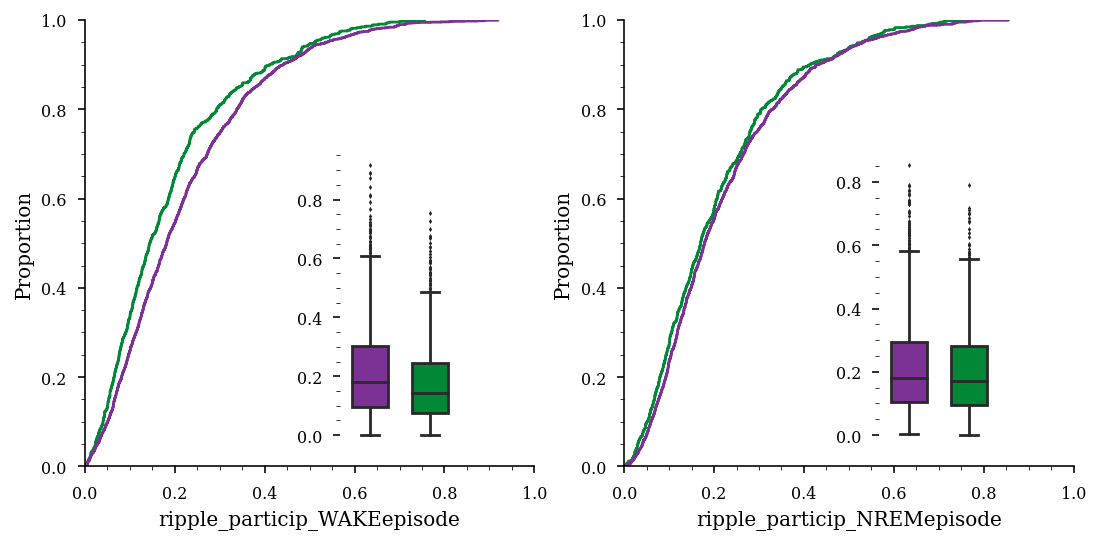

In [10]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837", "Middle": "orange"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(
    1,
    2,
    figsize=functions.set_size("thesis", fraction=1.5, subplots=(1.5, 2)),
    edgecolor="k",
)
idx = (
    (cell_metrics.deepSuperficial != "middle")
    & cell_metrics.putativeCellType.str.contains("Pyr")
    & cell_metrics.brainRegion.str.contains("CA1")
    & (cell_metrics.spikeCount > 200)
    & (cell_metrics.tags_bad_waveform != True)
    & (cell_metrics.tags_Bad != True)
)

ax_ = custom_plots.plot_ecdf_box(
    cell_metrics[idx],
    "ripple_particip_WAKEepisode",
    "deepSuperficial",
    group_colors.keys(),
    axs[0],
    fig,
    x_offset=0.2,
)
ax_ = custom_plots.plot_ecdf_box(
    cell_metrics[idx],
    "ripple_particip_NREMepisode",
    "deepSuperficial",
    group_colors.keys(),
    axs[1],
    fig,
    x_offset=0.2,
)
# axs[1].set_xscale("log")
# ax_.set_yscale("log")
axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)


In [7]:
from tqdm import tqdm


def collect_data(basepath):

    ripple_par = []
    state = []
    basepaths = []
    UID = []
    deepSuperficialDistance = []

    st, cell_metrics_ = loading.load_spikes(
        basepath, putativeCellType="Pyr", brainRegion="CA1"
    )

    st._data = st.data[(cell_metrics_.spikeCount > 200)]
    cell_metrics_ = cell_metrics_[(cell_metrics_.spikeCount > 200)]
    try:
        st._data = st.data[(cell_metrics_.tags_bad_waveform != True)]
        cell_metrics_ = cell_metrics_[(cell_metrics_.tags_bad_waveform != True)]
    except:
        pass

    state_dict = loading.load_SleepState_states(basepath)
    wake_state_epoch = nel.EpochArray(state_dict["WAKEstate"])
    nrem_state_epoch = nel.EpochArray(state_dict["NREMstate"])

    ripples = loading.load_ripples_events(basepath)
    ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    ripple_epochs = ripple_epochs.expand(0.05)

    # get ripple participation
    ripple_par.append(
        functions.get_participation(
            st[wake_state_epoch].data,
            ripple_epochs[wake_state_epoch].starts,
            ripple_epochs[wake_state_epoch].stops,
        ).mean(axis=1)
    )

    ripple_par.append(
        functions.get_participation(
            st[nrem_state_epoch].data,
            ripple_epochs[nrem_state_epoch].starts,
            ripple_epochs[nrem_state_epoch].stops,
        ).mean(axis=1)
    )
    state.append(["wake_state_epoch"] * st.data.shape[0])
    state.append(["nrem_state_epoch"] * st.data.shape[0])

    basepaths.append([basepath] * st.data.shape[0])
    basepaths.append([basepath] * st.data.shape[0])

    UID.append(cell_metrics_.UID)
    UID.append(cell_metrics_.UID)

    deepSuperficialDistance.append(cell_metrics_.deepSuperficialDistance)
    deepSuperficialDistance.append(cell_metrics_.deepSuperficialDistance)

    temp_df = pd.DataFrame()
    temp_df["basepath"] = np.hstack(basepaths)
    temp_df["UID"] = np.hstack(UID)
    temp_df["deepSuperficialDistance"] = np.hstack(deepSuperficialDistance)
    temp_df["state"] = np.hstack(state)
    temp_df["ripple_par"] = np.hstack(ripple_par)
    return temp_df


temp_df = pd.DataFrame()
for basepath in tqdm(df.basepath.unique()):
    temp_df = pd.concat([temp_df, collect_data(basepath)], ignore_index=True)


100%|██████████| 64/64 [11:36<00:00, 10.88s/it]


In [8]:
temp_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(temp_df)


In [ ]:
idx = (
    (cell_metrics.deepSuperficial != "middle")
    & cell_metrics.putativeCellType.str.contains("Pyr")
    & cell_metrics.brainRegion.str.contains("CA1")
    & (cell_metrics.spikeCount > 200)
    & (cell_metrics.tags_bad_waveform != True)
    & (cell_metrics.tags_Bad != True)
)
cell_metrics[idx]


a = np.unique(
    cell_metrics[idx]["basepath"] + "_" + cell_metrics[idx]["UID"].astype(str)
)

idx = temp_df.deepSuperficial != "middle"
b = np.unique(temp_df[idx]["basepath"] + "_" + temp_df[idx]["UID"].astype(str))
set(a) ^ set(b)


(0.0, 1.0)

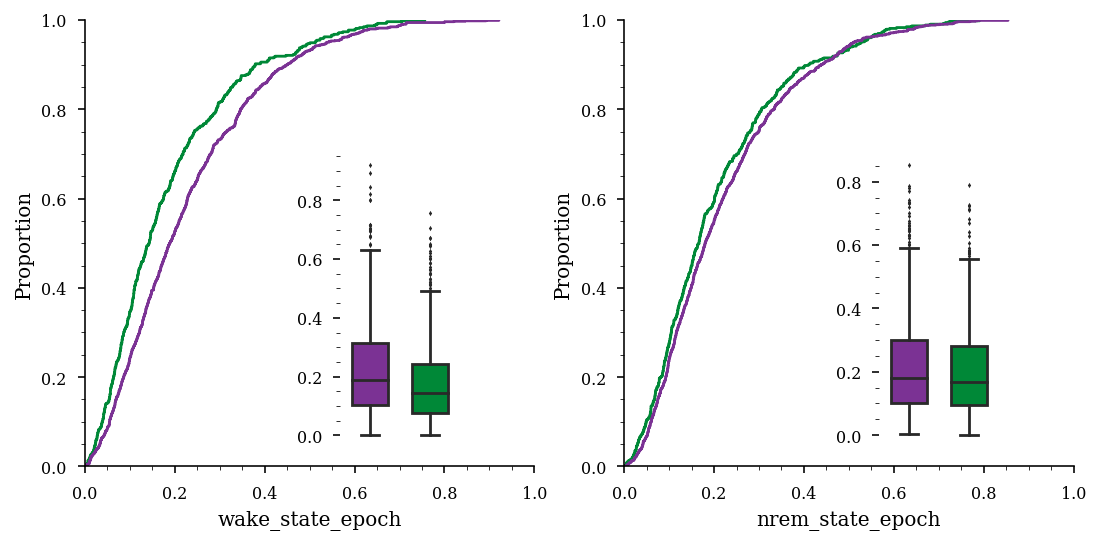

In [9]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837", "Middle": "orange"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(
    1,
    2,
    figsize=functions.set_size("thesis", fraction=1.5, subplots=(1.5, 2)),
    edgecolor="k",
)
idx = (temp_df.deepSuperficial != "Middle") & (temp_df.state == "wake_state_epoch")
ax_ = custom_plots.plot_ecdf_box(
    temp_df[idx],
    "ripple_par",
    "deepSuperficial",
    group_colors.keys(),
    axs[0],
    fig,
    x_offset=0.2,
)
axs[0].set_xlabel("wake_state_epoch")

idx = (temp_df.deepSuperficial != "Middle") & (temp_df.state == "nrem_state_epoch")
ax_ = custom_plots.plot_ecdf_box(
    temp_df[idx],
    "ripple_par",
    "deepSuperficial",
    group_colors.keys(),
    axs[1],
    fig,
    x_offset=0.2,
)
axs[1].set_xlabel("nrem_state_epoch")
# axs[1].set_xscale("log")
# ax_.set_yscale("log")
axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)
